In [3]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [4]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
from pathlib import Path
# import all samples as dictionary ...
from samples import *

In [6]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [7]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-white')
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
from matplotlib.gridspec import GridSpec
import bbi
from cooltools import snipping

In [8]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]
hg19_arms.to_csv("hg19_arms.bed",sep="\t",index=False,header=False)

In [9]:
conditions = ['442-NT','442-IAA']
binsize = 2000
binsize_human = f"{int(binsize/1_000)}kb"

cooler_paths = {    
    '442-NT' : f'CkoCT442-NT-pool.mcool::resolutions/{binsize}',
    '442-IAA' : f'CkoCT442-IAA-pool.mcool::resolutions/{binsize}',
}
long_names = {
    '442-NT' : 'CTCFdegron-442-nontreated-pool',
    '442-IAA': 'CTCFdegron-442-auxin-pool',
}

pal = sns.color_palette('colorblind')
colors = {
    '442-NT': "#e74c3c",
    '442-IAA': pal[2],
}
clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [10]:
# iterate over samples to calculate insulation on:
for cond in conditions:
    lname,*_ = cooler_paths[cond].split(".mcool")
    target_exp_file = Path(f"{lname}.{binsize_human}.cis.exp.tsv")
    if target_exp_file.is_file():
        print("already exist !")
        print(target_exp_file)
        continue
    else:
        print("working on ...")
        print(cond,lname)
        ######################################
        !cooltools compute-expected \
            --nproc 4 \
            --output {target_exp_file} \
            --regions hg19_arms.bed \
            --contact-type cis \
            --balance \
            --weight-name weight \
            --ignore-diags 2 \
            {cooler_paths[cond]}
        ######################################


already exist !
CkoCT442-NT-pool.2kb.cis.exp.tsv
already exist !
CkoCT442-IAA-pool.2kb.cis.exp.tsv


In [11]:
expected_paths = {    
    '442-NT' : f'CkoCT442-NT-pool.{binsize_human}.cis.exp.tsv',
    '442-IAA' : f'CkoCT442-IAA-pool.{binsize_human}.cis.exp.tsv',
}
expecteds = {
    cond: pd.read_csv(expected_paths[cond], sep="\t") for cond in conditions
}

In [13]:
#CTCF-only pairwise
sites = pd.read_table('upstreamCTCF_pTSS.bedpe', delimiter='\t')
sites['mid1'] = (sites['start1'] + sites['end1'])/2
sites['mid2'] = (sites['start2'] + sites['end2'])/2
print(len(sites))
sites.head()

7543


,chrom1,start1,end1,chrom2,start2,end2,mid1,mid2
0,chr1,875596,875897,chr1,1243959,1243964,875746.5,1243961.5
1,chr1,875596,875897,chr1,1260181,1260186,875746.5,1260183.5
2,chr1,919017,919979,chr1,1243959,1243964,919498.0,1243961.5
3,chr1,919017,919979,chr1,1260181,1260186,919498.0,1260183.5
4,chr1,1057249,1057885,chr1,1371069,1371074,1057567.0,1371071.5


In [14]:
snippet_flank = 50_000
windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom1'], 
    sites['mid1'],
    flank_bp=snippet_flank)

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom2'], 
    sites['mid2'],
    flank_bp=snippet_flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, hg19_arms) # function "assign_regions" might move
windows = windows.dropna() # do we need this ?
windows.head()

,chrom1,start1,end1,lo1,hi1,chrom2,start2,end2,lo2,hi2,region
0,chr1,824000,926000,412,463,chr1,1192000,1294000,596,647,chr1p
1,chr1,824000,926000,412,463,chr1,1210000,1312000,605,656,chr1p
2,chr1,868000,970000,434,485,chr1,1192000,1294000,596,647,chr1p
3,chr1,868000,970000,434,485,chr1,1210000,1312000,605,656,chr1p
4,chr1,1006000,1108000,503,554,chr1,1320000,1422000,660,711,chr1p


In [15]:
stacks = {}
piles = {}
for cond in conditions:
    snipper = snipping.ObsExpSnipper(clrs[cond], expecteds[cond], regions=hg19_arms)
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

In [20]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)


Text(0.5, 0.98, '(50)kb flank\nHi-C resolution = 2kb; # of pairs = 7543')

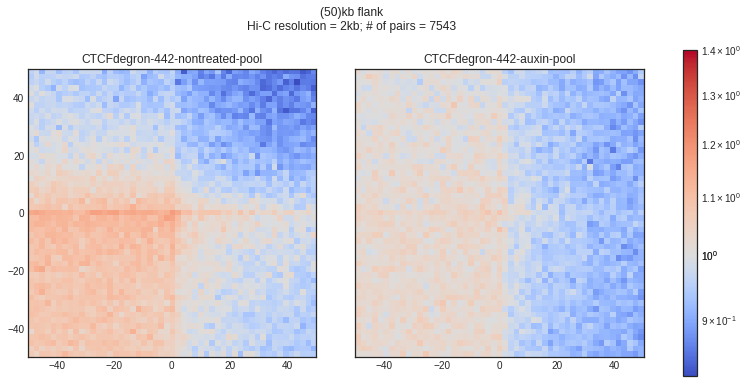

In [23]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.82,vmax=1.4,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'({snippet_flank//1000})kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)}')